In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 载入数据集

In [2]:
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

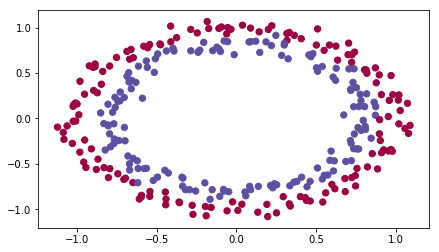

In [3]:
# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

### 深层神经网络（隐藏层ReLU 输出层sigmoid）

In [4]:
# sigmoid激活函数
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [5]:
# ReLU激活函数
def relu(Z):
    return np.maximum(0, Z)

In [6]:
# 初始化深层神经网络的参数 尝试3种不同的方式

# 使用0初始化
def initialize_parameters_zeros(layers_dims):
    parameters = {}
    
    # 深层神经网络的层数+1
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

# 用较大的随机数初始化
def initialize_parameters_random(layers_dims):
    parameters = {}
    
    # 深层神经网络的层数+1
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

# 使用HE初始化
def initialize_parameters_he(layers_dims):
    parameters = {}
    
    # 深层神经网络的层数+1
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1] / 2)
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [7]:
# 计算正向传播 ReLU->ReLU->...->Sigmoid
def forward_propagate(parameters, X):
    L = len(parameters) // 2
    
    caches = {}
    
    A = X
    caches['A0'] = A
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        A = relu(Z)
        caches['A' + str(l)] = A
    
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    A = sigmoid(Z)
    caches['A' + str(L)] = A
    
    return A, caches

In [8]:
# 计算损失函数
def compute_cost(AL, Y):
    logprobs = Y * np.log(AL) + (1 - Y) * np.log(1 - AL)
    cost = -np.nanmean(logprobs)
    return cost

In [9]:
# 计算反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate(parameters, Y, caches):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = dZ @ caches['A' + str(L - 1)].T / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = dZ @ caches['A' + str(l - 1)].T / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

In [10]:
# 用梯度下降法更新参数
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

In [11]:
# 训练深层神经网络模型
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, initialization = "he"):
    # 初始化参数 W1 b1 ... WL bL
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    
    # 损失函数记录
    costs = []
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        AL, caches = forward_propagate(parameters, X)
        if print_cost and i % 1000 == 0:
            cost = compute_cost(AL, Y)
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
        grads = backward_propagate(parameters, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘制损失函数
    if print_cost:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [12]:
# 对样本进行预测
def predict(parameters, X):
    AL, caches = forward_propagate(parameters, X)
    AL = AL > 0.5
    return AL.astype(np.int)

In [13]:
# 计算准确率
def compute_accuracy(parameters, X, Y):
    P = predict(parameters, X)
    return float((Y @ P.T + (1 - Y) @ (1 - P.T)) / float(Y.size))

In [14]:
# 绘制决策边界图
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

### 训练深层神经网络模型

In [15]:
# 设定深层神经网络层数和各层节点数 共3层
layers_dims = [train_X.shape[0], 10, 5, 1]

Cost after iteration 0: 0.693147
Cost after iteration 1000: 0.693147
Cost after iteration 2000: 0.693147
Cost after iteration 3000: 0.693147
Cost after iteration 4000: 0.693147
Cost after iteration 5000: 0.693147
Cost after iteration 6000: 0.693147
Cost after iteration 7000: 0.693147
Cost after iteration 8000: 0.693147
Cost after iteration 9000: 0.693147
Cost after iteration 10000: 0.693147
Cost after iteration 11000: 0.693147
Cost after iteration 12000: 0.693147
Cost after iteration 13000: 0.693147
Cost after iteration 14000: 0.693147


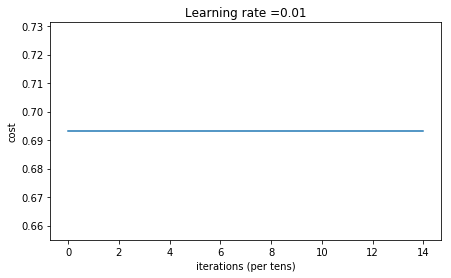

In [16]:
# 训练深层神经网络模型 使用0初始化
parameters = L_layer_model(train_X, train_Y, layers_dims, learning_rate = 0.01, num_iterations = 15000, print_cost=True, initialization = "zeros")

In [17]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 50%
测试集准确率: 50%


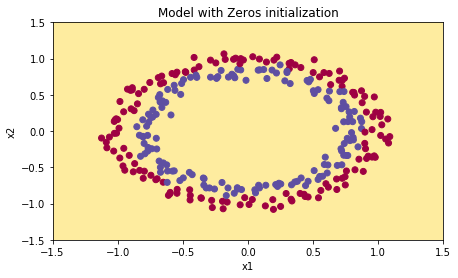

In [18]:
# 绘制决策边界图
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after iteration 0: inf
Cost after iteration 1000: 0.491038
Cost after iteration 2000: 0.342510
Cost after iteration 3000: 0.328911
Cost after iteration 4000: 0.314939
Cost after iteration 5000: 0.303939
Cost after iteration 6000: 0.294096
Cost after iteration 7000: 0.325862
Cost after iteration 8000: 0.257537
Cost after iteration 9000: 0.250673
Cost after iteration 10000: 0.246024
Cost after iteration 11000: 0.242711
Cost after iteration 12000: 0.237905
Cost after iteration 13000: 0.235167
Cost after iteration 14000: 0.231835


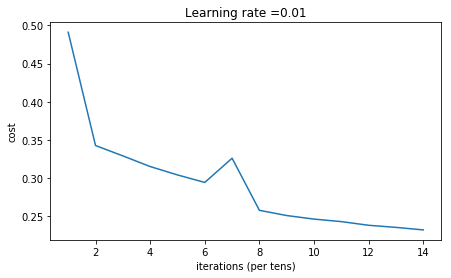

In [19]:
# 训练深层神经网络模型 使用大随机数初始化
parameters = L_layer_model(train_X, train_Y, layers_dims, learning_rate = 0.01, num_iterations = 15000, print_cost=True, initialization = "random")

In [20]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 88%
测试集准确率: 85%


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


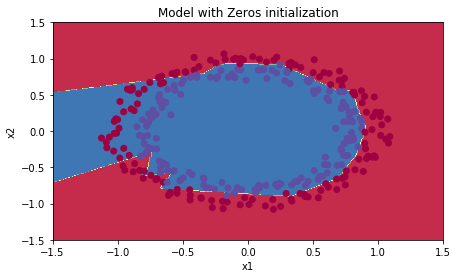

In [21]:
# 绘制决策边界图
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])

Cost after iteration 0: 0.735197
Cost after iteration 1000: 0.682378
Cost after iteration 2000: 0.668560
Cost after iteration 3000: 0.657376
Cost after iteration 4000: 0.641608
Cost after iteration 5000: 0.618381
Cost after iteration 6000: 0.586347
Cost after iteration 7000: 0.539670
Cost after iteration 8000: 0.485865
Cost after iteration 9000: 0.393008
Cost after iteration 10000: 0.288322
Cost after iteration 11000: 0.212278
Cost after iteration 12000: 0.161240
Cost after iteration 13000: 0.126986
Cost after iteration 14000: 0.103913


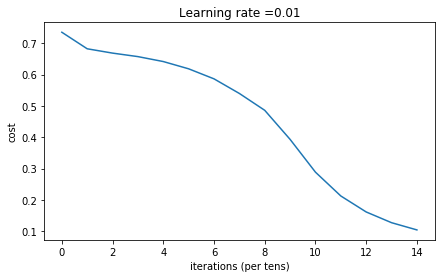

In [22]:
# 训练深层神经网络模型 使用HE初始化
parameters = L_layer_model(train_X, train_Y, layers_dims, learning_rate = 0.01, num_iterations = 15000, print_cost=True, initialization = "he")

In [23]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_X, test_Y) * 100) + '%')

训练集准确率: 99%
测试集准确率: 94%


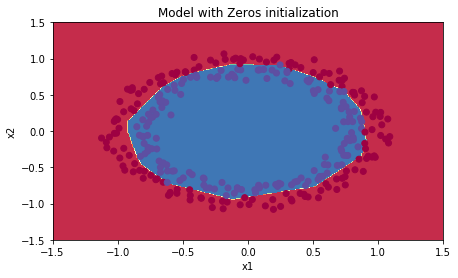

In [24]:
# 绘制决策边界图
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])